# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import re

In [2]:
# create a Spark session
from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [22]:
# 10% smaller
## load data
import pandas as pd
file = 'mini_sparkify_event_data.json.bz2'
pddf = pd.read_json(file,compression='bz2')
display(pddf.size)
pddf.head(1)

5157000

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016


In [23]:
## smaller
pddf_small = pddf.sample(frac=0.1)
display(pddf_small.size)
pddf_small.head(1)

515700

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
63292,1539960630000,,1050,Home,Logged Out,GET,200,paid,69,None,None,None,None,NaN,None,None,None,NaN


In [24]:
## new file name
newfile = '10pre_' + file
newfile

'10pre_mini_sparkify_event_data.json.bz2'

In [27]:
## persistence compression
pddf_small.to_json(newfile,compression='bz2')

In [28]:
## persistence normal
pddf_small.to_json('10pre_mini_sparkify_event_data.json')

In [16]:
'''
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-27414cb1-6f23-43f7-b5c4-068f7ddd28df',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'XqTOGm6hBHQPBph0av9FxudyXZZx7phmmVrkAVZN05NE'
}

configuration_name = 'os_7bc372256f5b42afa24a39e2c2637134_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')
''';

In [17]:
'''
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ldhntltm3yvkv2'))
df.take(5)
''';

In [3]:
# 使用压缩格式会死掉，cpu很高但无反应，后续要救
## 另外，最好使用 bz2 （gz也行但压缩率没有bz2高） 
## 这两种格式是 splittble 的，可以使用所有 spark 节点读取
#df = spark.read.json('mini_sparkify_event_data.json')
## 不设定名字貌似最后一步会报错,和ibm有关，drop，研究a'w's
df = spark.read.json('mini_sparkify_event_data.json', 'sparkify-donotdelete-pr-ldhntltm3yvkv2')
df.take(1)

ParseException: "\nextraneous input '-' expecting {'SELECT', 'FROM', 'ADD', 'AS', 'ALL', 'ANY', 'DISTINCT', 'WHERE', 'GROUP', 'BY', 'GROUPING', 'SETS', 'CUBE', 'ROLLUP', 'ORDER', 'HAVING', 'LIMIT', 'AT', 'OR', 'AND', 'IN', NOT, 'NO', 'EXISTS', 'BETWEEN', 'LIKE', RLIKE, 'IS', 'NULL', 'TRUE', 'FALSE', 'NULLS', 'ASC', 'DESC', 'FOR', 'INTERVAL', 'CASE', 'WHEN', 'THEN', 'ELSE', 'END', 'JOIN', 'CROSS', 'OUTER', 'INNER', 'LEFT', 'SEMI', 'RIGHT', 'FULL', 'NATURAL', 'ON', 'PIVOT', 'LATERAL', 'WINDOW', 'OVER', 'PARTITION', 'RANGE', 'ROWS', 'UNBOUNDED', 'PRECEDING', 'FOLLOWING', 'CURRENT', 'FIRST', 'AFTER', 'LAST', 'ROW', 'WITH', 'VALUES', 'CREATE', 'TABLE', 'DIRECTORY', 'VIEW', 'REPLACE', 'INSERT', 'DELETE', 'INTO', 'DESCRIBE', 'EXPLAIN', 'FORMAT', 'LOGICAL', 'CODEGEN', 'COST', 'CAST', 'SHOW', 'TABLES', 'COLUMNS', 'COLUMN', 'USE', 'PARTITIONS', 'FUNCTIONS', 'DROP', 'UNION', 'EXCEPT', 'MINUS', 'INTERSECT', 'TO', 'TABLESAMPLE', 'STRATIFY', 'ALTER', 'RENAME', 'ARRAY', 'MAP', 'STRUCT', 'COMMENT', 'SET', 'RESET', 'DATA', 'START', 'TRANSACTION', 'COMMIT', 'ROLLBACK', 'MACRO', 'IGNORE', 'BOTH', 'LEADING', 'TRAILING', 'IF', 'POSITION', 'EXTRACT', 'DIV', 'PERCENT', 'BUCKET', 'OUT', 'OF', 'SORT', 'CLUSTER', 'DISTRIBUTE', 'OVERWRITE', 'TRANSFORM', 'REDUCE', 'SERDE', 'SERDEPROPERTIES', 'RECORDREADER', 'RECORDWRITER', 'DELIMITED', 'FIELDS', 'TERMINATED', 'COLLECTION', 'ITEMS', 'KEYS', 'ESCAPED', 'LINES', 'SEPARATED', 'FUNCTION', 'EXTENDED', 'REFRESH', 'CLEAR', 'CACHE', 'UNCACHE', 'LAZY', 'FORMATTED', 'GLOBAL', TEMPORARY, 'OPTIONS', 'UNSET', 'TBLPROPERTIES', 'DBPROPERTIES', 'BUCKETS', 'SKEWED', 'STORED', 'DIRECTORIES', 'LOCATION', 'EXCHANGE', 'ARCHIVE', 'UNARCHIVE', 'FILEFORMAT', 'TOUCH', 'COMPACT', 'CONCATENATE', 'CHANGE', 'CASCADE', 'RESTRICT', 'CLUSTERED', 'SORTED', 'PURGE', 'INPUTFORMAT', 'OUTPUTFORMAT', DATABASE, DATABASES, 'DFS', 'TRUNCATE', 'ANALYZE', 'COMPUTE', 'LIST', 'STATISTICS', 'PARTITIONED', 'EXTERNAL', 'DEFINED', 'REVOKE', 'GRANT', 'LOCK', 'UNLOCK', 'MSCK', 'REPAIR', 'RECOVER', 'EXPORT', 'IMPORT', 'LOAD', 'ROLE', 'ROLES', 'COMPACTIONS', 'PRINCIPALS', 'TRANSACTIONS', 'INDEX', 'INDEXES', 'LOCKS', 'OPTION', 'ANTI', 'LOCAL', 'INPATH', IDENTIFIER, BACKQUOTED_IDENTIFIER}(line 1, pos 8)\n\n== SQL ==\nsparkify-donotdelete-pr-ldhntltm3yvkv2\n--------^^^\n"

In [23]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

display(df.persist)
display(df_valid.select("userId").dropDuplicates().sort("userId").show())
display(df_valid.select("sessionId").dropDuplicates().sort("userId").show())

<bound method DataFrame.persist of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]>

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



None

+---------+
|sessionId|
+---------+
|      299|
|     1059|
|      347|
|      237|
|      241|
|       54|
|      330|
|     1338|
|     1217|
|      564|
|     2263|
|      926|
|      656|
|      270|
|      293|
|     1532|
|     1409|
|     1277|
|     2088|
|       22|
+---------+
only showing top 20 rows



None

In [24]:
df_valid = df_valid.filter(df["userId"] != "")
df_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
# see what values page feature holds
df_valid.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [28]:
# create a list for churn users
## 使用 Cancellation Confirmation 来定义客户流失
churn_user_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_user_list = [user["userId"] for user in churn_user_df.collect()]
churn_user_list[:10]

['125', '51', '54', '100014', '101', '29', '100021', '87', '73', '3']

In [29]:
# create a column for churn
df_valid = df_valid.withColumn("churn", df_valid.userId.isin(churn_user_list))
df_valid

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: boolean]

#### // group by gender

In [30]:
# show gender difference in churn
df_valid.dropDuplicates(['userId']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



#### // gender divided played songs stats

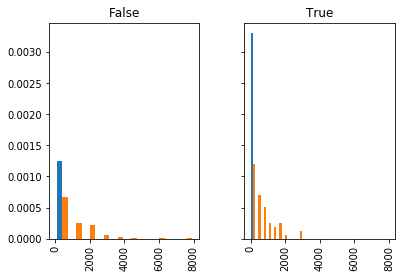

In [32]:
df_valid_songs = df_valid.where(df_valid.song!='null').groupby(['churn','userId']) \
    .agg(count(df_valid.song).alias('SongsPlayed')).orderBy('churn').toPandas()
df_valid_songs.hist(['SongsPlayed'], by='churn', sharex=True, sharey=True,density=1)
plt.plot();

#### // gender divided thumps-up/down stats

ThumbsUps for people who stay 62.89411764705882
ThumbsUps for people who leave 37.18


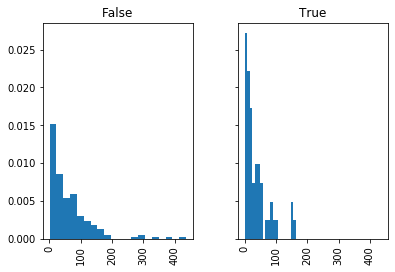

In [36]:
# up
df_valid_thumbsup = df_valid.where(df_valid.page=='Thumbs Up') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('churn').toPandas()
df_valid_thumbsup.hist('ThumbsUps', by='churn', bins=20, sharex=True, sharey=True, density=1);

print('ThumbsUps for people who stay',df_valid_thumbsup[df_valid_thumbsup['churn']==False]['ThumbsUps'].mean())
print('ThumbsUps for people who leave',df_valid_thumbsup[df_valid_thumbsup['churn']==True]['ThumbsUps'].mean())

C:\Users\mengf\Miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\mengf\Miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


ThumbsDowns for people who stay 12.735294117647058
ThumbsDowns for people who leave 11.545454545454545


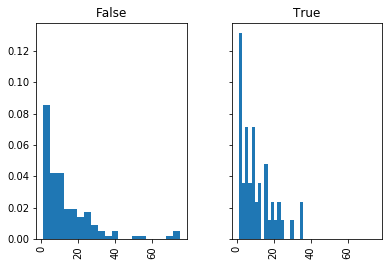

In [38]:
# down
df_valid_thumbsdown = df_valid.where(df_valid.page=='Thumbs Down') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('churn').toPandas()
df_valid_thumbsdown.hist('ThumbsDowns', by='churn', bins=20, sharex=True, sharey=True, density=1);

print('ThumbsDowns for people who stay',df_valid_thumbsdown[df_valid_thumbsup['churn']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',df_valid_thumbsdown[df_valid_thumbsup['churn']==True]['ThumbsDowns'].mean())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [39]:
# pick gender as first feature
df_gender = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1', '0'], 'gender')
df_gender.withColumn('gender', df_gender.gender.cast("int"))

df_gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



In [40]:
# pick number of songs played as second feature
df_songs = df_valid.where(df_valid.song!='null').groupby('userId') \
    .agg(count(df_valid.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])
df_songs.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [42]:
# pick number of thumbs up and thumps down as third and fourth feature
df_thumbsup = df_valid.where(df_valid.page=='Thumbs Up') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])
df_thumbsdown = df_valid.where(df_valid.page=='Thumbs Down') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])
df_thumbsup.show(),df_thumbsdown.show();

+------+---------+
|userId|ThumbsUps|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
|100004|       35|
|100005|        7|
|100006|        2|
|100007|       19|
|100008|       37|
|100009|       23|
|100010|       17|
|100012|       18|
|100013|       39|
|100014|       17|
|100015|       35|
|100016|       25|
|100017|        2|
|100018|       46|
|100019|        1|
+------+---------+
only showing top 20 rows

+------+-----------+
|userId|ThumbsDowns|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
|100006|          2|
|100007|          6|
|100008|          6|
|100009|          8|
|100010|          5|
|100011|          1|
|100012|          9|
|100013|         15|
|100014|          3|
|100015|          8|
|100016|          5|
|100017|          1|
|100018|          9|
|100019|          1|
|100021|          5|
+------+-----------+
only showing t

In [43]:
# pick the number of singers user has listened as fifth feature
df_singers = df_valid.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_valid.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])
df_singers.show()

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
|100009|            442|
|100010|            252|
|100011|             11|
|100012|            397|
|100013|            826|
|100014|            233|
|100015|            627|
|100016|            431|
|100017|             51|
|100018|            780|
+------+---------------+
only showing top 20 rows



In [44]:
# join features
df_final = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [df_gender, df_songs,df_thumbsup,df_thumbsdown,df_singers]:
    df_final = df_final.join(feature,'userId')
    
df_final.show()

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|false|     1|        275|       17|          5|            252|
|200002|false|     0|        387|       21|          6|            339|
|   124|false|     1|       4079|      171|         41|           2232|
|    51| true|     0|       2111|      100|         21|           1385|
|     7|false|     0|        150|        7|          1|            142|
|    15|false|     0|       1914|       81|         14|           1302|
|    54| true|     1|       2841|      163|         29|           1744|
|   155|false|     1|        820|       58|          3|            643|
|100014| true|     0|        257|       17|          3|            233|
|   132|false|     1|       1928|       96|         17|           1299|
|   101| true|     0|       1797|       86|         16|         

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [45]:
# check
df_final.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('gender', 'string'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('SingersListened', 'bigint')]

In [47]:
# convert data type of columns into float
for feature in df_final.columns[1:]:
    df_final = df_final.withColumn(feature,df_final[feature].cast('float'))
    
df_final.dtypes

[('userId', 'string'),
 ('churn', 'float'),
 ('gender', 'float'),
 ('SongsPlayed', 'float'),
 ('ThumbsUps', 'float'),
 ('ThumbsDowns', 'float'),
 ('SingersListened', 'float')]

In [49]:
# 特别慢！ spark 在mac 和windows经常这样，需要研究下
df_final.show(5)

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|  0.0|   1.0|      275.0|     17.0|        5.0|          252.0|
|200002|  0.0|   0.0|      387.0|     21.0|        6.0|          339.0|
|   124|  0.0|   1.0|     4079.0|    171.0|       41.0|         2232.0|
|    51|  1.0|   0.0|     2111.0|    100.0|       21.0|         1385.0|
|     7|  0.0|   0.0|      150.0|      7.0|        1.0|          142.0|
+------+-----+------+-----------+---------+-----------+---------------+
only showing top 5 rows



In [50]:
# train test split
train, test = df_final.randomSplit([0.8, 0.2], seed=42)

In [51]:
# pipeline
assembler = VectorAssembler(inputCols=df_final.columns[2:],outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)


pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, 0.01]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)


cvModel_lr = crossval_lr.fit(train)

Py4JJavaError: An error occurred while calling o5188.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 4468.0 failed 1 times, most recent failure: Lost task 1.0 in stage 4468.0 (TID 95899, localhost, executor driver): java.io.FileNotFoundException: File file:/C:/Users/mengf/Documents/GitHub/udacity-private/_dsnd/p4_capestone/project_sparkify/mini_sparkify_event_data.json does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:224)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:91)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:391)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:391)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.doExecute(WholeStageCodegenExec.scala:383)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.inputRDDs(SortMergeJoinExec.scala:386)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.doExecute(WholeStageCodegenExec.scala:383)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.inputRDDs(SortMergeJoinExec.scala:386)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.doExecute(WholeStageCodegenExec.scala:383)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.inputRDDs(SortMergeJoinExec.scala:386)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.doExecute(WholeStageCodegenExec.scala:383)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.inputRDDs(SortMergeJoinExec.scala:386)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.doExecute(WholeStageCodegenExec.scala:383)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.inputRDDs(SortMergeJoinExec.scala:386)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:271)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:41)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.DeserializeToObjectExec.doExecute(objects.scala:89)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.Dataset.rdd$lzycompute(Dataset.scala:3043)
	at org.apache.spark.sql.Dataset.rdd(Dataset.scala:3041)
	at org.apache.spark.ml.classification.LogisticRegressionSummary$class.$init$(LogisticRegression.scala:1400)
	at org.apache.spark.ml.classification.LogisticRegressionSummaryImpl.<init>(LogisticRegression.scala:1655)
	at org.apache.spark.ml.classification.BinaryLogisticRegressionSummaryImpl.<init>(LogisticRegression.scala:1697)
	at org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl.<init>(LogisticRegression.scala:1676)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:893)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:494)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:489)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:279)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: File file:/C:/Users/mengf/Documents/GitHub/udacity-private/_dsnd/p4_capestone/project_sparkify/mini_sparkify_event_data.json does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [ ]:
cvModel_lr.avgMetrics

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.